In [2]:
%who

Interactive namespace is empty.


In [2]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(processes = False) #, n_workers = 4) #n_workers = 4, processes=True) #n_workers = 4, memory = "44GB") #threads_per_worker = 1)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 1
Total threads: 16,Total memory: 44.92 GiB
Status: running,Using processes: False
Comm: inproc://10.0.128.134/1721944/1,Workers: 1
Dashboard: /proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 44.92 GiB
Comm: inproc://10.0.128.134/1721944/4,Total threads: 16
Dashboard: /proxy/35233/status,Memory: 44.92 GiB
Nanny: None,


In [3]:
cluster.scale(cores=2)

In [4]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 1
Total threads: 4,Total memory: 11.23 GiB
Status: running,Using processes: False
Comm: inproc://10.0.128.134/1720057/1,Workers: 1
Dashboard: /proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 11.23 GiB
Comm: inproc://10.0.128.134/1720057/5,Total threads: 4
Dashboard: /proxy/35245/status,Memory: 11.23 GiB
Nanny: None,


In [2]:
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=8,memory="31GB",walltime='00:30:00')
client = Client(cluster)
cluster.scale(cores=8)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.128.143:41067,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [4]:
! scancel 8556

In [3]:
! squeue -u ad9701

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
              8520       vdi sys/dash   ad9701  R    4:30:55      1 ood-vn27
              8537       vdi sys/dash   ad9701  R    3:10:35      1 ood-vn27
              8561       vdi sys/dash   ad9701  R    1:03:31      1 ood-vn8


In [2]:
%%time

# set up a cluster
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=8,memory="31GB",walltime='01:30:00')
client = Client(cluster)
cluster.scale(cores=8)
client

import xarray as xr
import numpy as np
import pandas as pd
import glob

projdir = '/g/data/w97/ad9701/p_prob_analysis/temp_files/'
out_dir = projdir + 'sm_droughts/'
prefix = "events"

awra_dir = '/g/data/fj8/BoM/AWRA/DATA/SCHEDULED-V6/processed/values/day/'
file_names = 'sm_[1-2]*.nc'

lat_slice = slice(-32, -39)
lon_slice = slice(139, 152)
startyr_list = list(range(1911, 2021, 10))

# identifying drought based on an array created for two thresholds
# lowFlag for start of drought (10th perc) & highFlag for the end of drought (30th perc)
def identify_drought(x, prevDrght = None, lowFlag = -100, highFlag = 100, btwFlag = 0):
    '''x is a numpy array. 
    -100 (lowFlag) corresponds to values less than 10th perc, 
    +100 (highFlag) corresponds to greater than 30th perc, 
    0 (btwFlag) is between 10 & 30 where drought depends on the days leading upto the specific day
    function returns a 0 & 1 array, where 1 corresponds to drought
    prevDrght indicates whether the last day from the previous time sclice was in drought or not (0 or 1)
    ''' 
    y = np.zeros(len(x), dtype = int)
    droughtInd = np.where(x == lowFlag)       # days at which the grid is in drought (sm < drought threshold)
    y[droughtInd] = 1
    if (prevDrght == 1) & (x[0] != highFlag): # if the previous day is in drought & first day from this time slice did not exceed highFlag
        y[0] = 1
    btwInd = np.where(x == btwFlag)[0]        # days at which the grid may be in drought depending on the days leading upto that day

    if len(btwInd) > 0:                       # if such days exist
        for i in btwInd:
            if i != 0:                        # skip the first day
                if y[i-1] == 1:               # if the previous day was in drought the btwDay would also be in drought
                    y[i] = 1
    return(y)

# # Testing the function
# x = np.array([0, 0, 100, -100, -100, 0, 0, 0, 100, 0])    
# y = identify_drought(x, prevDrght = 0)
# print(x)
# print(y)

def create_filepath(ds, prefix='filename', root_path="."):
    """
    Generate a filepath when given an xarray dataset or dataarray
    """
    start = ds.time[0].dt.strftime("%Y-%m").data
    end = ds.time[-1].dt.strftime("%Y-%m").data
    filepath = f'{root_path}/{prefix}_{start}_{end}.nc'
    return filepath

perc_drought_start = 0.1     # this is the thershold percentile to identify dry soil moisture conditions
perc_drought_end = 0.3

for i in range(5, len(startyr_list)):
    startyr_sel = startyr_list[i]
    time_slice = slice(str(startyr_sel) + '-01-01', str(startyr_sel + 9) + '-12-31') #slice('1911-01-02','2020-03-29')

    # get the daily soil moisture dataset
    ds_temp = xr.open_mfdataset(awra_dir + file_names) #, chunks = {'latitude':40,'longitude':40})
    # converting the datatypes of SM to match P
    lat_new = np.float32(ds_temp['latitude'])
    lon_new = np.float32(ds_temp['longitude'])
    ds = ds_temp.rename({'latitude':'lat','longitude':'lon'}).assign_coords(lat = lat_new, lon = lon_new).sel(lat = lat_slice, lon = lon_slice, time = time_slice)
    da_sm_temp = ds['sm'].chunk(chunks = {'time':-1})

    # get the reference quantiles used to identify drought
    ds_sm_perc = xr.open_dataset(projdir + 'sm_refPeriod_perc/sm_191101_to_202005_perc.nc')
    # day of year is not properly assigned in the dataset of percentiles; reassigning
    dayofyear = np.arange(366) + 1
    da_sm_low = ds_sm_perc['sm'].sel(quantile = perc_drought_start).assign_coords(dayofyear = dayofyear)
    da_sm_high = ds_sm_perc['sm'].sel(quantile = perc_drought_end).assign_coords(dayofyear = dayofyear)
    
    # select the threshold values corresponding to each day of the year from the soil moisture dataset
    ds_doy = np.array(ds['time.dayofyear'])   # day of the year in ds, the sm dataset
    ds_start_thresh = da_sm_low.sel(dayofyear = ds_doy)
    ds_end_thresh = da_sm_high.sel(dayofyear = ds_doy)

    # create a data array with high & low flags to identify when sm crosses the thersholds
    da_sm = da_sm_temp.reset_index('time').rename({'time':'dayofyear', 'time_':'time'}).assign_coords({'dayofyear': ds_doy})
    da_sm_start_thresh = xr.where(da_sm <= ds_start_thresh, -100, 0).reset_index('dayofyear').rename({'dayofyear':'time','dayofyear_':'dayofyear'})
    da_sm_end_thresh = xr.where(da_sm >= ds_end_thresh, 100, 0).reset_index('dayofyear').rename({'dayofyear':'time','dayofyear_':'dayofyear'})
    da_sm_thresh = da_sm_start_thresh + da_sm_end_thresh

    # identify drought events
    # dask_gufunc_kwargs = {'allow_rechunk':True}
    if i >= 1:
        prev_events_file = ''.join(glob.glob(out_dir + prefix + '_' + str(startyr_list[i-1]) + '*.nc'))
        ds_drought_prev = xr.open_dataset(prev_events_file)
        da_prev = ds_drought_prev['sm_drought'].isel(time = -1)
        da_drought = xr.apply_ufunc(
            identify_drought,                      # first the function, this function returns a tuple (GLM params, GLM pvalues, GLM modelled probabilities)
            da_sm_thresh,                          # function arg
            da_prev,
            input_core_dims = [["time"], []],          # list with one entry per arg, these are the dimensions not to be broadcast
            output_core_dims = [["time"]],         # dimensions of the output
            vectorize = True,                      # broadcast over non-core dimensions of the input object?
            dask = "parallelized",                 # enable dask?                     
            # dask_gufunc_kwargs=dask_gufunc_kwargs,
            output_dtypes = [int]
        )
    else:
        da_drought = xr.apply_ufunc(
            identify_drought,                      # first the function, this function returns a tuple (GLM params, GLM pvalues, GLM modelled probabilities)
            da_sm_thresh,                          # function arg
            input_core_dims = [["time"]],      # list with one entry per arg, these are the dimensions not to be broadcast
            output_core_dims = [["time"]],         # dimensions of the output
            vectorize = True,                      # broadcast over non-core dimensions of the input object?
            dask = "parallelized",                 # enable dask?                     
            # dask_gufunc_kwargs=dask_gufunc_kwargs,
            output_dtypes = [int]
        )
        
    da_drought = da_drought.rename('sm_drought').drop('dayofyear', errors = 'ignore')
    out_file = create_filepath(da_drought, prefix = prefix, root_path = out_dir)
    da_drought
    da_drought.to_netcdf(out_file)

cluster.scale(cores = 0)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41455 instead
  warnings.warn(


CPU times: user 4min 32s, sys: 3min 14s, total: 7min 46s
Wall time: 17min 44s


In [5]:
da_drought

<xarray.DataArray 'sm_drought' (lat: 141, lon: 261, time: 3653)>
dask.array<transpose, shape=(141, 261, 3653), dtype=int64, chunksize=(141, 261, 3653), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -32.0 -32.05 -32.1 -32.15 ... -38.9 -38.95 -39.0
  * lon      (lon) float32 139.0 139.1 139.1 139.1 ... 151.9 151.9 151.9 152.0
  * time     (time) datetime64[ns] 1931-01-01 1931-01-02 ... 1940-12-31

In [3]:
da_drought.rename('sm_drought').drop('dayofyear')

<xarray.DataArray 'sm_drought' (lat: 141, lon: 261, time: 3653)>
dask.array<transpose, shape=(141, 261, 3653), dtype=int64, chunksize=(141, 261, 3653), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -32.0 -32.05 -32.1 -32.15 ... -38.9 -38.95 -39.0
  * lon      (lon) float32 139.0 139.1 139.1 139.1 ... 151.9 151.9 151.9 152.0
  * time     (time) datetime64[ns] 1931-01-01 1931-01-02 ... 1940-12-31

In [4]:
da_drought = da_drought.drop('dayofyear')

In [9]:
da_drought.drop('dayofyear', errors = 'ignore')

<xarray.DataArray 'sm_drought' (lat: 141, lon: 261, time: 3653)>
dask.array<transpose, shape=(141, 261, 3653), dtype=int64, chunksize=(141, 261, 3653), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -32.0 -32.05 -32.1 -32.15 ... -38.9 -38.95 -39.0
  * lon      (lon) float32 139.0 139.1 139.1 139.1 ... 151.9 151.9 151.9 152.0
  * time     (time) datetime64[ns] 1931-01-01 1931-01-02 ... 1940-12-31

In [ ]:
da_drought

In [ ]:
import xarray as xr
import numpy as np
import pandas as pd

projdir = '/g/data/w97/ad9701/p_prob_analysis/temp_files/'
out_dir = projdir + 'sm_droughts/'
prefix = "events"



### Scratch Space

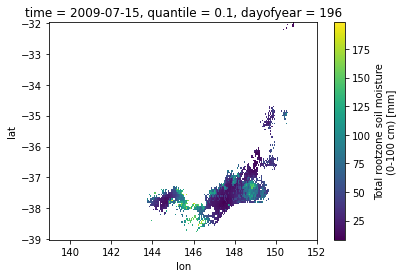

In [48]:
ds_drought.sel(time = '2009-07-15').plot()

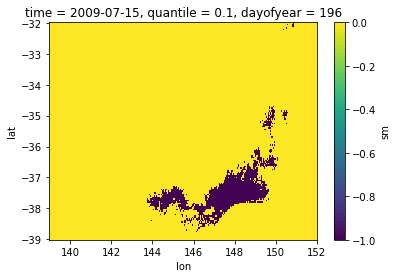

In [3]:
da_sm_drought_start.sel(time = '2009-07-15').plot()

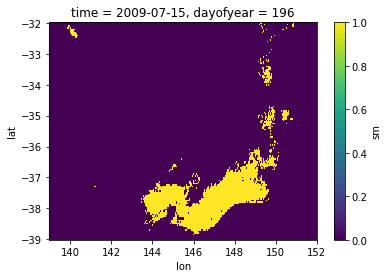

In [8]:
da_drought.sel(time = '2009-07-15').plot()

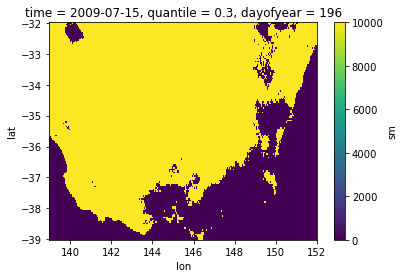

In [4]:
da_sm_drought_end.sel(time = '2009-07-15').plot()

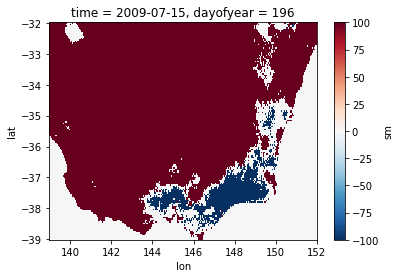

In [5]:
da_sm_thresh.sel(time = '2009-07-15').plot()

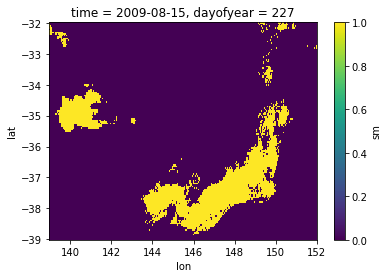

In [10]:
da_drought.sel(time = '2009-08-15').plot()

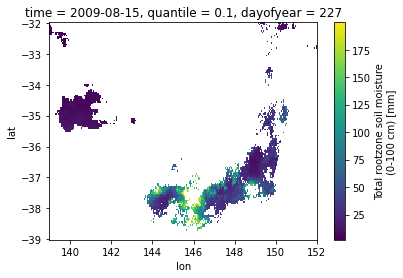

In [49]:
ds_drought.sel(time = '2009-08-15').plot()

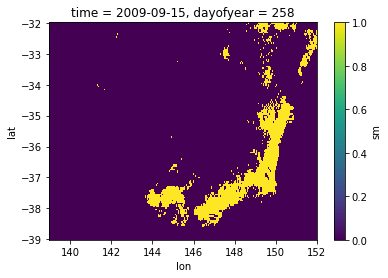

In [11]:
da_drought.sel(time = '2009-09-15').plot()

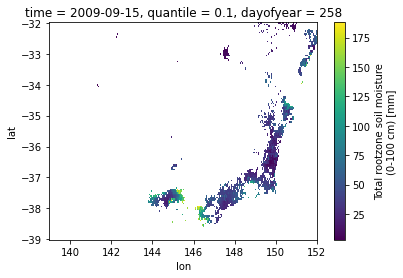

In [50]:
ds_drought.sel(time = '2009-09-15').plot()

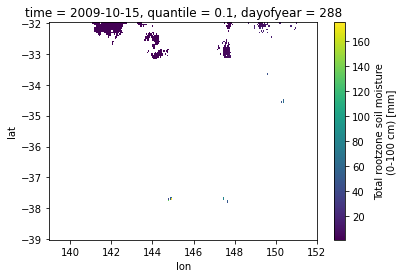

In [51]:
ds_drought.sel(time = '2009-10-15').plot()

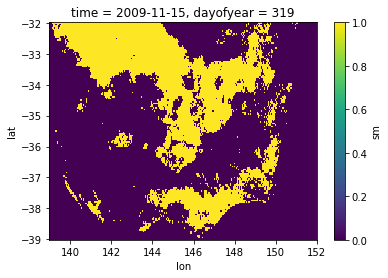

In [12]:
da_drought.sel(time = '2009-11-15').plot()

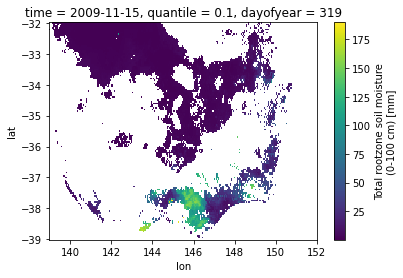

In [52]:
ds_drought.sel(time = '2009-11-15').plot()

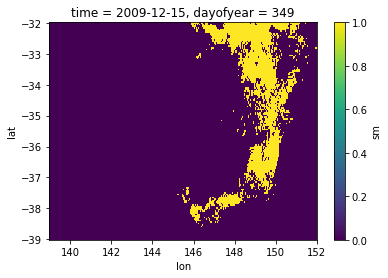

In [13]:
da_drought.sel(time = '2009-12-15').plot()

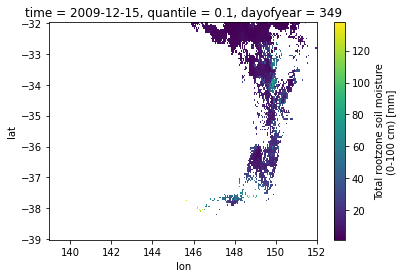

In [53]:
ds_drought.sel(time = '2009-12-15').plot()

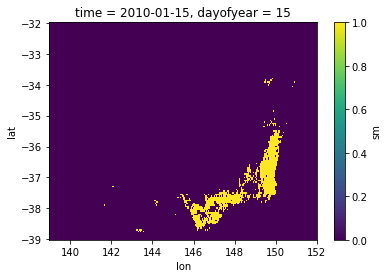

In [14]:
da_drought.sel(time = '2010-01-15').plot()

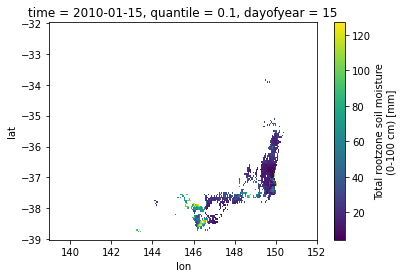

In [54]:
ds_drought.sel(time = '2010-01-15').plot()

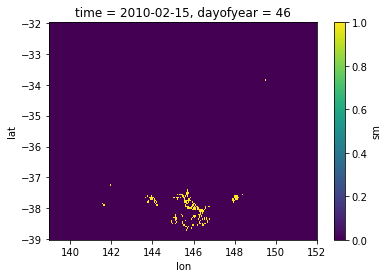

In [15]:
da_drought.sel(time = '2010-02-15').plot()

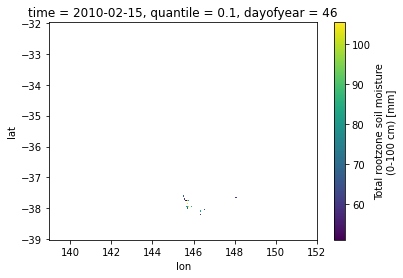

In [55]:
ds_drought.sel(time = '2010-02-15').plot()

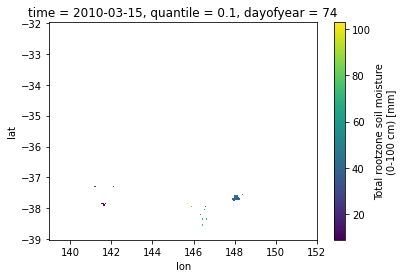

In [56]:
ds_drought.sel(time = '2010-03-15').plot()

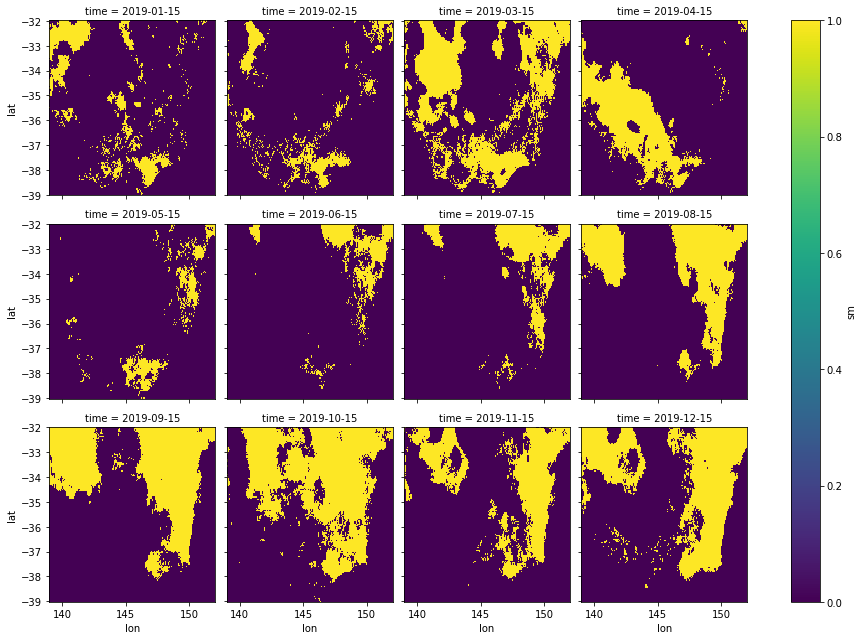

In [20]:
time_sel = ['2019-01-15', '2019-02-15', '2019-03-15', '2019-04-15', '2019-05-15', '2019-06-15', \
            '2019-07-15', '2019-08-15', '2019-09-15', '2019-10-15', '2019-11-15', '2019-12-15']
da_drought.sel(time = time_sel).plot(x = "lon", y = "lat", col = "time", col_wrap = 4)

In [19]:
da_drought.time[-10:]

<xarray.DataArray 'time' (time: 10)>
array(['2020-05-22T00:00:00.000000000', '2020-05-23T00:00:00.000000000',
       '2020-05-24T00:00:00.000000000', '2020-05-25T00:00:00.000000000',
       '2020-05-26T00:00:00.000000000', '2020-05-27T00:00:00.000000000',
       '2020-05-28T00:00:00.000000000', '2020-05-29T00:00:00.000000000',
       '2020-05-30T00:00:00.000000000', '2020-05-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time       (time) datetime64[ns] 2020-05-22 2020-05-23 ... 2020-05-31
    dayofyear  (time) int64 143 144 145 146 147 148 149 150 151 152
Attributes:
    long_name:      time
    standard_name:  time
    name:           time

In [57]:
import xarray as xr
import numpy as np
import pandas as pd

projdir = '/g/data/w97/ad9701/p_prob_analysis/temp_files/'

awra_dec_dir = '/g/data/fj8/BoM/AWRA/DATA/SCHEDULED-V6/processed/deciles/day/'
dec_file_names = 'ss_pct_*.nc'

lat_slice = slice(-32, -39)
lon_slice = slice(139, 152)
time_slice = slice('2009-07-01', '2010-06-30') #slice('1911-01-02','2020-03-29')

ds_dec_temp = xr.open_mfdataset(awra_dec_dir + dec_file_names, chunks = {'lat':400,'lon':400})
# converting the datatypes of SM to match P
lat_new = np.float32(ds_dec_temp['latitude'])
lon_new = np.float32(ds_temp['longitude'])
ds_dec = ds_dec_temp.rename({'latitude':'lat','longitude':'lon'}).assign_coords(lat = lat_new, lon = lon_new).sel(lat = lat_slice, lon = lon_slice, time = time_slice)
ds_dec



<xarray.Dataset>
Dimensions:  (time: 365, lat: 141, lon: 261)
Coordinates:
  * time     (time) datetime64[ns] 2009-07-01 2009-07-02 ... 2010-06-30
  * lat      (lat) float32 -32.0 -32.05 -32.1 -32.15 ... -38.9 -38.95 -39.0
  * lon      (lon) float32 139.0 139.1 139.1 139.1 ... 151.9 151.9 151.9 152.0
Data variables:
    ss_pct   (time, lat, lon) float32 dask.array<chunksize=(184, 141, 261), meta=np.ndarray>
Attributes:
    var_name:       ss_pct
    date_modified:  2018-11-08T06:19:51
    email:          awrams@bom.gov.au
    Conventions:    CF-1.6, ACDD-1.3
    summary:        Data produced by Bureau of Meteorology Australian Water R...
    institution:    Bureau of Meteorology
    url:            http://www.bom.gov.au/water/landscape
    date_created:   2018-11-08T06:19:51
    source:         AWRA-L-v5)
    title:          Australian Landscape Water Balance AWRA-L Model Version 5

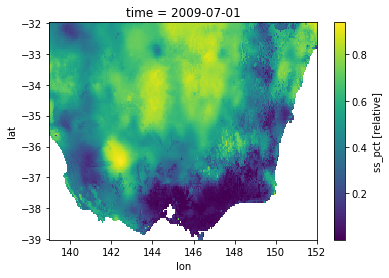

In [61]:
ds_dec['ss_pct'][0,:,:].plot()

In [4]:
3650*10000

36500000

In [1]:
! squeue -u ad9701

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
              8228      main dask-wor   ad9701  R       0:41      1 ood-n6
              8213       vdi sys/dash   ad9701  R    2:44:31      1 ood-vn2
